**import Required libraries :**


In [14]:
import cv2
import urllib.request
import matplotlib.pyplot as plt

**Tracking colorful objects using MeanShift
and CamShift :**

We have seen that background subtraction can be an effective technique for detecting
moving objects; however, we know that it has some inherent limitations. Notably, it
assumes that the current background can be predicted based on past frames. This
assumption is fragile. For example, if the camera moves, the entire background model
could suddenly become outdated. Thus, in a robust tracking system, it is important to build
some kind of model of foreground objects rather than just the background.
Once we have detected a moving object (by background subtraction or other means), we
would like to describe the object in a way that distinguishes it from other moving objects. In
this way, we can continue to identify and track the object even if it crosses paths with
another moving object. A color histogram may serve as a sufficiently unique description.
Essentially, an object's color histogram is an estimate of the probability distribution of pixel
colors in the object. For example, the histogram could indicate that each pixel in the object is
10% likely to be blue. The histogram is based on the actual colors observed in the object's
region of a reference image.

In [15]:
# Create a background subtractor using the MOG2 method with shadow detection enabled.
bg_subtractor = cv2.createBackgroundSubtractorMOG2(detectShadows=True)

# Define the kernel sizes for erosion and dilation
erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
dilate_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))

# URL to the raw video file on GitHub
video_url = "https://github.com/ZahraEk/OpenCV-Course/raw/main/videos/car_racing.mp4"

# Download the video
video_filename = "car_racing.mp4"
urllib.request.urlretrieve(video_url, video_filename)

# Open the video file for reading
cap = cv2.VideoCapture(video_filename)

# Initialize a video capture
#cap = cv2.VideoCapture(0)
      
# Capture a frame from the camera
success, frame = cap.read()
while success:
    
    # Apply background subtraction to get the foreground mask
    fg_mask = bg_subtractor.apply(frame)

    # Apply thresholding to create a binary image
    _, thresh = cv2.threshold(fg_mask, 244, 255, cv2.THRESH_BINARY)

    # Apply morphological erosion and dilation to smoothen the thresholded image
    cv2.erode(thresh, erode_kernel, thresh, iterations=2)
    cv2.dilate(thresh, dilate_kernel, thresh, iterations=2)

    # Find contours of objects in the thresholded image
    contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Loop through detected contours and draw bounding rectangles for large ones
    for c in contours:
        if cv2.contourArea(c) > 1000:
            x, y, w, h = cv2.boundingRect(c)
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)
    
    cv2.imshow('MOG', fg_mask)
    cv2.imshow('Thresh', thresh)
    cv2.imshow('Detection', frame)

    k = cv2.waitKey(1)
    if k == 27:  # Escape
        break

    # Capture a frame from the camera
    success, frame = cap.read()

# Release the video capture object and close OpenCV windows
cap.release()
cv2.destroyAllWindows()

**Mouse Callback Function (draw_rectangle):**

In summary, this code allows you to draw rectangles on video frames, capture the regions within those rectangles, and save them as separate images. It's commonly used in tasks like object localization and tracking in computer vision applications.

`Mouse Callback Function (draw_rectangle):`

•This function handles mouse events (clicking and releasing) for drawing rectangles and cropping images.

•When the left mouse button is pressed (EVENT_LBUTTONDOWN), it records the initial coordinates (ix, iy).

•When the left mouse button is released (EVENT_LBUTTONUP), it draws a rectangle on the frame and captures the ROI.

•It appends the ROI to cropped_images and displays it in a window named "ROI".


In [29]:
# Define global variables
drawing = False  # True if mouse is pressed
ix, iy = -1, -1  # Initial coordinates
cropped_images = []  # List to store cropped images

# Mouse callback function to drawing rectangle and crop image
def draw_rectangle(event, x, y, flags, param):
    global ix, iy, drawing, frame

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        ix, iy = x, y

    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        cv2.rectangle(frame, (ix, iy), (x, y), (0, 0, 0), 2)
        roi = frame[iy:y, ix:x]
        cropped_images.append(roi)
        cv2.imshow('ROI', roi)

# Create a video capture object
cap = cv2.VideoCapture(video_filename)

# Capture 20 frames to allow the camera's autoexposure to adjust.
for i in range(20):
    success, frame = cap.read()
if not success:
    exit(1)

# Set the callback function for mouse events
cv2.namedWindow('Frame')
cv2.setMouseCallback('Frame', draw_rectangle)

while True:
    cv2.imshow('Frame', frame)
    k = cv2.waitKey(1)
    if k == 27:  # Escape key
        break

    elif k == ord('s'):  # 's' key to save cropped image
        if len(cropped_images) > 0:
            cv2.imwrite('roi.jpg', cropped_images[-1])  # Save the last cropped image

# Release the video capture object and close OpenCV windows
cap.release()
cv2.destroyAllWindows()


By the 20th frame, we assume that the exposure is good; therefore, we can extract
an accurate histogram of a region of interest. The following code defines the
bounds of the **region of interest (ROI):**


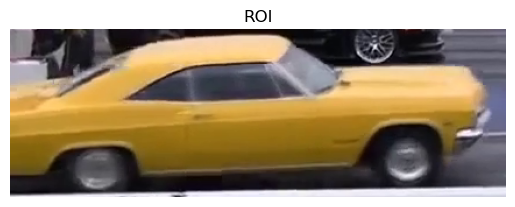

In [30]:
cap = cv2.VideoCapture(video_filename)

# Capture 20 frames to allow the camera's autoexposure to adjust.
for i in range(20):
    success, frame = cap.read()
if not success:
    exit(1)

# Define an initial tracking window for a specific object.
frame_h, frame_w = frame.shape[:2]
w = frame_w // 3  # Adjust the width of the window
h = frame_h // 5  # Adjust the height of the window
x = 10  # Adjust the x-coordinate of the top-left corner of the window
y = 400  # Adjust the y-coordinate of the top-left corner of the window
track_window = (x, y, w, h)

roi = frame[y:y+h, x:x+w]

plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
plt.title('ROI')
plt.axis('off')
plt.show()

---

# cv2.calcHist : 

`cv2.calcHist(images, channels, mask, histSize, ranges[, hist[, accumulate]])`


• **images:** The input image (or images). It can be a single image or a list of images.

• **channels:** The list of color channels you want to create histograms for. For example, [0] for grayscale, and

For **BGR** channels:

`[0]` for calculating the histogram of the blue channel **(Blue)**

`[1]` for calculating the histogram of the green channel **(Green)**

`[2]` for calculating the histogram of the red channel **(Red)**


• **mask:** A mask to specify the region of the image that participates in the histogram calculation.(Optional)

• **histSize:** The number of bins or levels in the histogram for each channel.

• **ranges:** The range of each bin in each channel. For example, [0, 256] for BGR channels.

• **hist:** The resulting histogram array (Optional).

• **accumulate:** A flag that indicates whether to accumulate the previous histogram or not.(Optional)

Using these parameters, we can calculate different histograms and use them for histogram back-projection.


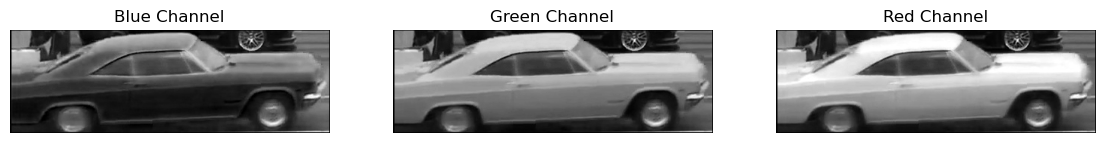

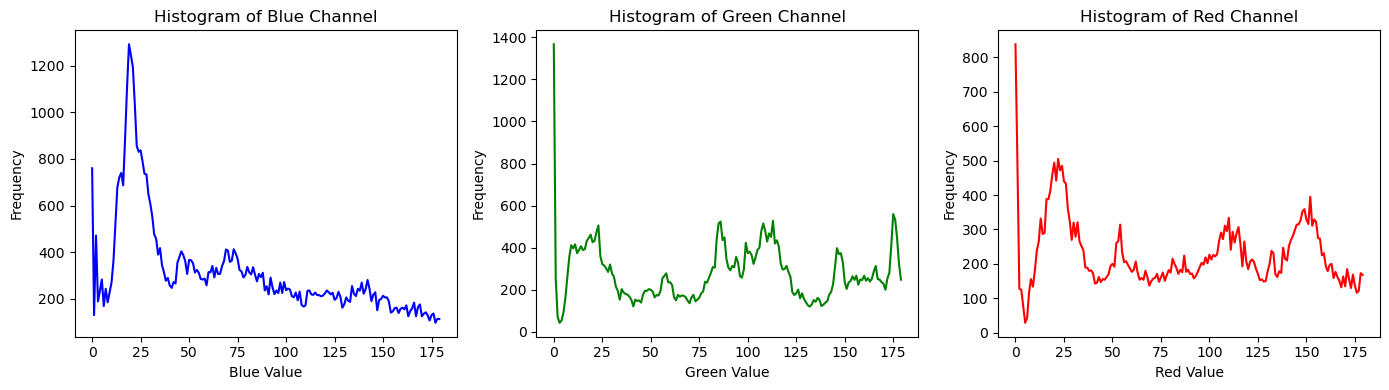

In [31]:
# Read roi image
roi = cv2.imread("roi.jpg")

# Splitting the image into R, G, and B channels
b, g, r = cv2.split(roi)

# Displaying the channels
plt.figure(figsize=(14, 4))

plt.subplot(131)
plt.imshow(b, cmap='gray')
plt.title('Blue Channel')
plt.axis('off')

plt.subplot(132)
plt.imshow(g, cmap='gray')
plt.title('Green Channel')
plt.axis('off')

plt.subplot(133)
plt.imshow(r, cmap='gray')
plt.title('Red Channel')
plt.axis('off')

plt.show()

# Define a mask (optional, currently set to None)
mask = None

# Calculating histograms for the R, G, and B channels
b_hist = cv2.calcHist([roi], [0], mask, [180], [0, 180])
g_hist = cv2.calcHist([roi], [1], mask, [180], [0, 180])
r_hist = cv2.calcHist([roi], [2], mask, [180], [0, 180])

# Displaying the histograms of the channels
plt.figure(figsize=(14, 4))

plt.subplot(131)
plt.plot(b_hist, color='b')
plt.title('Histogram of Blue Channel')
plt.xlabel('Blue Value')
plt.ylabel('Frequency') 

plt.subplot(132)
plt.plot(g_hist, color='g')
plt.title('Histogram of Green Channel')
plt.xlabel('Green Value')
plt.ylabel('Frequency')

plt.subplot(133)
plt.plot(r_hist, color='r')
plt.title('Histogram of Red Channel')
plt.xlabel('Red Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

---
`cv2.calcHist(images, channels, mask, histSize, ranges[, hist[, accumulate]])`

**channels:** The list of color channels you want to create histograms. 

For **HSV** channels:

•`[0]` for calculating the histogram of the hue channel **(Hue)**

•`[1]` for calculating the histogram of the saturation channel **(Saturation)**

•`[2]` for calculating the histogram of the value channel **(Value)**

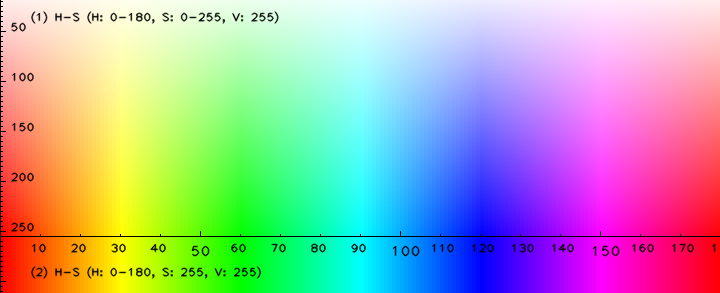

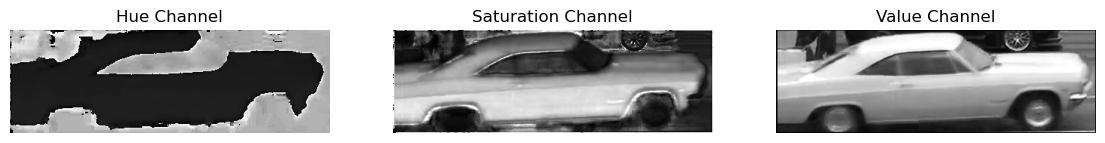

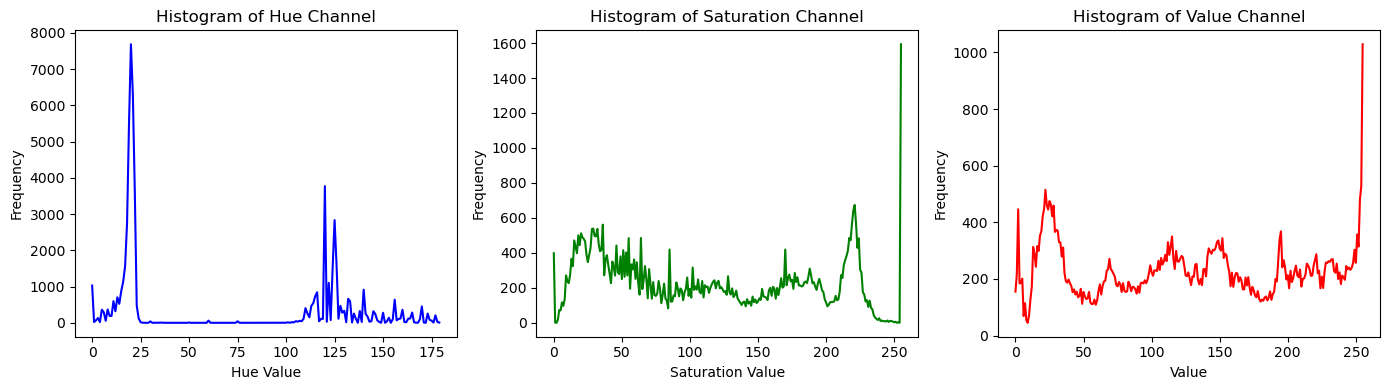

In [32]:
# Convert ROI to HSV color space
hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

# Split the HSV image into H, S, and V channels
h, s, v = cv2.split(hsv_roi)

# Display the channels
plt.figure(figsize=(14, 4))

plt.subplot(131)
plt.imshow(h, cmap='gray')
plt.title('Hue Channel')
plt.axis('off')

plt.subplot(132)
plt.imshow(s, cmap='gray')
plt.title('Saturation Channel')
plt.axis('off')

plt.subplot(133)
plt.imshow(v, cmap='gray')
plt.title('Value Channel')
plt.axis('off')

plt.show()

# Define a mask (optional, currently set to None)
mask = None

# Calculate histograms for the H, S, and V channels
h_hist = cv2.calcHist([hsv_roi], [0], mask, [180], [0, 180])
s_hist = cv2.calcHist([hsv_roi], [1], mask, [256], [0, 256])
v_hist = cv2.calcHist([hsv_roi], [2], mask, [256], [0, 256])

# Display the histograms
plt.figure(figsize=(14, 4))

plt.subplot(131)
plt.plot(h_hist, color='b')
plt.title('Histogram of Hue Channel')
plt.xlabel('Hue Value')
plt.ylabel('Frequency') 

plt.subplot(132)
plt.plot(s_hist, color='g')
plt.title('Histogram of Saturation Channel')
plt.xlabel('Saturation Value')
plt.ylabel('Frequency')

plt.subplot(133)
plt.plot(v_hist, color='r')
plt.title('Histogram of Value Channel')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

---
# cv2.calcBackProject :

Back Projection is a way of recording how well the pixels of a given image fit the distribution of pixels in a histogram model.

To make it simpler: For Back Projection, you calculate the histogram model of a feature and then use it to find this feature in an image.

`cv2.calcBackProject(images, channels, hist, ranges, scale[, dst])` 

• **images:** The input image (or images). It can be a single image or a list of images.

• **channels:** This parameter is the list of the indices of the channels used to compute the back projection. For example, channels=`[0]` means that only the first channel (channel with index 0) is used.

• **hist:** This parameter is the histogram that we want to back project. It should be a 1D or 2D histogram.

• **ranges:** This parameter is the range of values for each dimension. It is a list of the ranges for each channel.

• **scale:** This parameter is a scaling factor applied to the back projection. It adjusts the overall intensity of the output.

• **dst:** This is the optional output destination. If not specified, a new array is created.

The function returns the back-projected image.


 ---
# MeanShift :

The intuition behind the meanshift is simple. Consider you have a set of points. (It can be a pixel distribution like histogram backprojection). You are given a small window (may be a circle) and you have to move that window to the area of maximum pixel density (or maximum number of points). It is illustrated in the simple image given below:

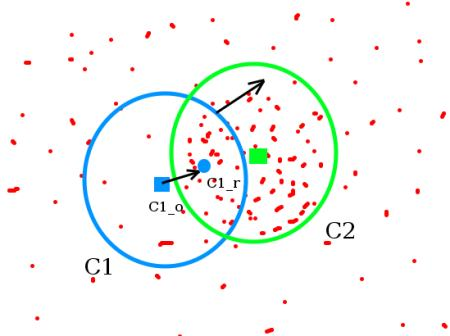

The initial window is shown in blue circle with the name "C1". Its original center is marked in blue rectangle, named "C1_o". But if you find the centroid of the points inside that window, you will get the point "C1_r" (marked in small blue circle) which is the real centroid of the window. Surely they don't match. So move your window such that the circle of the new window matches with the previous centroid. Again find the new centroid. Most probably, it won't match. So move it again, and continue the iterations such that the center of window and its centroid falls on the same location (or within a small desired error). So finally what you obtain is a window with maximum pixel distribution. It is marked with a green circle, named "C2". As you can see in the image, it has maximum number of points. The whole process is demonstrated on a static image below:

https://docs.opencv.org/3.4/meanshift_face.gif

So we normally pass the histogram backprojected image and initial target location. When the object moves, obviously the movement is reflected in the histogram backprojected image. As a result, the meanshift algorithm moves our window to the new location with maximum density.

In [33]:
# Calculate the normalized HSV histogram of the initial window.
h_hist = cv2.calcHist([hsv_roi], [0], mask, [180], [0, 180])
cv2.normalize(h_hist, h_hist, 0, 255, cv2.NORM_MINMAX)

# Define the termination criteria:
# 10 iterations or convergence within 1-pixel radius.
term_crit = (cv2.TERM_CRITERIA_COUNT | cv2.TERM_CRITERIA_EPS, 10, 1)

# Capture a frame from the camera
success, frame = cap.read()
while success:
    
    # if frame is read correctly ret is True
    if not success:
        print("Can't receive frame (stream end?). Exiting ...")
        break
        
    # Perform back-projection of the HSV histogram onto the frame.
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    back_proj = cv2.calcBackProject([hsv], [0], h_hist, [0, 180], 1)

    # Perform tracking with MeanShift.
    num_iters, track_window = cv2.meanShift(back_proj, track_window, term_crit)

    # Draw the tracking window.
    x, y, w, h = track_window
    cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)
    
    # Display the resulting frame
    cv2.imshow('back-projection', back_proj)
    cv2.imshow('meanshift', frame)

    k = cv2.waitKey(30)
    if k == 27:  # Escape
        break
        
    # Capture a frame from the camera
    success, frame = cap.read()
    
# Release the video capture object and close OpenCV windows
cap.release()
cv2.destroyAllWindows()